In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [108]:
df = pd.read_csv('specPhotoDR18.csv')

In [109]:
df.head()

,photoz,specz,dered_u,dered_g,dered_r,dered_i,dered_z,petroRad_u,petroRad_g,petroRad_r,...,q_u,u_u,q_g,u_g,q_r,u_r,q_i,u_i,q_z,u_z
0,0.119464,1.168943,20.69754,19.61841,19.20132,18.93900,18.94013,0.092122,4.841318,5.268336,...,-0.206322,-0.509153,-0.061303,-0.432856,-0.075508,-0.538279,0.107235,-0.402515,-0.141832,-0.594173
1,0.119464,0.048808,20.69754,19.61841,19.20132,18.93900,18.94013,0.092122,4.841318,5.268336,...,-0.206322,-0.509153,-0.061303,-0.432856,-0.075508,-0.538279,0.107235,-0.402515,-0.141832,-0.594173
2,0.136151,0.066696,19.90209,19.00809,18.56176,18.25147,18.13738,2.251165,2.423817,2.429605,...,-0.070681,0.136154,-0.020168,0.087962,-0.002642,0.059072,-0.013288,0.055156,-0.045969,0.055755
3,0.136151,0.066705,19.90209,19.00809,18.56176,18.25147,18.13738,2.251165,2.423817,2.429605,...,-0.070681,0.136154,-0.020168,0.087962,-0.002642,0.059072,-0.013288,0.055156,-0.045969,0.055755
4,0.049357,0.023913,19.81616,18.67916,18.32420,18.14549,18.04588,2.831537,2.564563,2.788960,...,0.054747,0.027326,-0.010306,-0.038938,0.010906,-0.041018,-0.018247,-0.049057,-0.027200,-0.019351


In [110]:
df.dropna(inplace=True)

In [111]:
df['specz'].isnull().sum()

0

In [112]:
df.shape

(999672, 87)

In [114]:
X = df.drop(['photoz', 'specz'], axis=1)
y = df['specz']

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.5, random_state=42)  # 50% train, 50% temp
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 50% val, 50% test


## Extracting Important Features
---

In [ ]:
# Hyperparameters
n_forests = 25
n_estimators_list = [25, 50, 100, 150, 200]
min_samples_leaf_list = [1, 2, 3, 4, 5, 6]
random_seeds = [21, 42, 84, 99, 100]
train_sizes = [0.6, 0.7, 0.8]

feature_total_weights = {feature: 0 for feature in X.columns}
rank_counts = {'Rank 1': {}, 'Rank 2': {}, 'Rank 3': {}}
rank_weights = {'Rank 1': {}, 'Rank 2': {}, 'Rank 3': {}}

results_list = []

for i in range(n_forests):
    print(f"Running forest {i+1}/{n_forests}.... ")

    n_estimators = np.random.choice(n_estimators_list)
    min_samples_leaf = np.random.choice(min_samples_leaf_list)
    random_seed = np.random.choice(random_seeds)
    train_size = np.random.choice(train_sizes)

    X_train_varied, _, y_train_varied, _ = train_test_split(X_train, y_train, train_size=train_size, random_state=random_seed)

    rf = RandomForestRegressor(n_estimators=n_estimators, min_samples_leaf=min_samples_leaf, random_state=random_seed)
    ada = AdaBoostRegressor(estimator=rf, n_estimators=15, random_state=random_seed)

    ada.fit(X_train_varied, y_train_varied)

    importances = ada.feature_importances_
    sorted_indices = np.argsort(importances)[::-1]

    top_3_features = [X.columns[sorted_indices[j]] for j in range(3)]
    top_3_weights = [importances[sorted_indices[j]] for j in range(3)]

    for rank, (feature, weight) in enumerate(zip(top_3_features, top_3_weights), start=1):
        rank_label = f"Rank {rank}"
        
        if feature in rank_counts[rank_label]:
            rank_counts[rank_label][feature] += 1
        else:
            rank_counts[rank_label][feature] = 1
            
        if feature in rank_weights[rank_label]:
            rank_weights[rank_label][feature] += weight
        else:
            rank_weights[rank_label][feature] = weight

    for j, feature in enumerate(X.columns[sorted_indices]):
        feature_total_weights[feature] += importances[sorted_indices[j]]

    y_pred = ada.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    results_list.append({
        'Forest': i + 1,
        'n_estimators': n_estimators,
        'min_samples_leaf': min_samples_leaf,
        'random_seed': random_seed,
        'train_size': train_size,
        'MSE': mse
    })


Running forest 1/25.... 
Running forest 2/25.... 
Running forest 3/25.... 
Running forest 4/25.... 
Running forest 5/25.... 
Running forest 6/25.... 
Running forest 7/25.... 
Running forest 8/25.... 
Running forest 9/25.... 
Running forest 10/25.... 
Running forest 11/25.... 
Running forest 12/25.... 
Running forest 13/25.... 
Running forest 14/25.... 
Running forest 15/25.... 
Running forest 16/25.... 
Running forest 17/25.... 
Running forest 18/25.... 
Running forest 19/25.... 
Running forest 20/25.... 
Running forest 21/25.... 
Running forest 22/25.... 
Running forest 23/25.... 
Running forest 24/25.... 
Running forest 25/25.... 


In [ ]:
results = pd.DataFrame(results_list)

rank_counts_df = pd.DataFrame(rank_counts).fillna(0).astype(int)
rank_weights_df = pd.DataFrame(rank_weights).fillna(0)

total_weight_sum = sum(feature_total_weights.values())
normalized_feature_weights = { feature: weight / total_weight_sum for feature, weight in feature_total_weights.items() }

total_occurrence_df = pd.DataFrame([
        {"Feature": feature, "Feature_weights": normalized_weight} for feature, normalized_weight in normalized_feature_weights.items()
    ])
total_occurrence_df = total_occurrence_df.sort_values(by="Feature_weights", ascending=False).reset_index(drop=True)

rank_totals = {rank: sum(counts.values()) for rank, counts in rank_counts.items()}

Rank_df = pd.DataFrame([
        {
            "Feature": feature,
            "Rank": rank,
            "Occurrences": count,
            "Weight": (count / rank_totals[rank])* 100, 
        }
        for rank, rank_dict in rank_counts.items()
        for feature, count in rank_dict.items()
    ])
Rank_df = Rank_df.sort_values(by=["Rank", "Occurrences"], ascending=[True, False]).reset_index(drop=True)

In [118]:
results

,Forest,n_estimators,min_samples_leaf,random_seed,train_size,MSE
0,1,200,6,100,0.8,0.023396
1,2,100,2,21,0.6,0.022511
2,3,25,3,99,0.7,0.022762
3,4,50,5,100,0.6,0.023897
4,5,50,2,100,0.6,0.023430
5,6,150,3,99,0.8,0.023117
6,7,100,2,84,0.8,0.022586
7,8,150,3,21,0.6,0.023766
8,9,100,2,21,0.7,0.022096
9,10,50,4,84,0.7,0.023608


In [119]:
rank_counts_df

,Rank 1,Rank 2,Rank 3
fiberMag_r,16,4,3
fiberMag_z,1,0,1
expRad_g,1,1,0
psfColor_gu,1,0,2
fiberColor_ir,1,0,1
fiberMag_u,1,0,0
expAB_g,1,0,0
deVAB_r,3,6,2
dered_r,0,4,4
deVRad_z,0,2,0


In [120]:
rank_weights_df

,Rank 1,Rank 2,Rank 3
fiberMag_r,3.544204,0.475479,0.288747
fiberMag_z,0.301160,0.000000,0.062996
expRad_g,0.132087,0.108363,0.000000
psfColor_gu,0.291137,0.000000,0.167192
fiberColor_ir,0.075500,0.000000,0.048626
fiberMag_u,0.113445,0.000000,0.000000
expAB_g,0.199648,0.000000,0.000000
deVAB_r,0.920354,0.989448,0.241248
dered_r,0.000000,0.487742,0.262265
deVRad_z,0.000000,0.125213,0.000000


In [121]:
Rank_df

,Feature,Rank,Occurrences,Weight
0,fiberMag_r,Rank 1,16,64.0
1,deVAB_r,Rank 1,3,12.0
2,fiberMag_z,Rank 1,1,4.0
3,expRad_g,Rank 1,1,4.0
4,psfColor_gu,Rank 1,1,4.0
5,fiberColor_ir,Rank 1,1,4.0
6,fiberMag_u,Rank 1,1,4.0
7,expAB_g,Rank 1,1,4.0
8,deVAB_r,Rank 2,6,24.0
9,dered_r,Rank 2,4,16.0


In [122]:
total_occurrence_df

,Feature,Feature_weights
0,fiberMag_r,0.177523
1,deVAB_r,0.088045
2,dered_r,0.048026
3,dered_g,0.043420
4,fiberMag_g,0.039121
...,...,...
80,q_i,0.000855
81,fracDeV_i,0.000737
82,fracDeV_r,0.000691
83,fracDeV_u,0.000678


#### Feature Imporatnce vs Weights

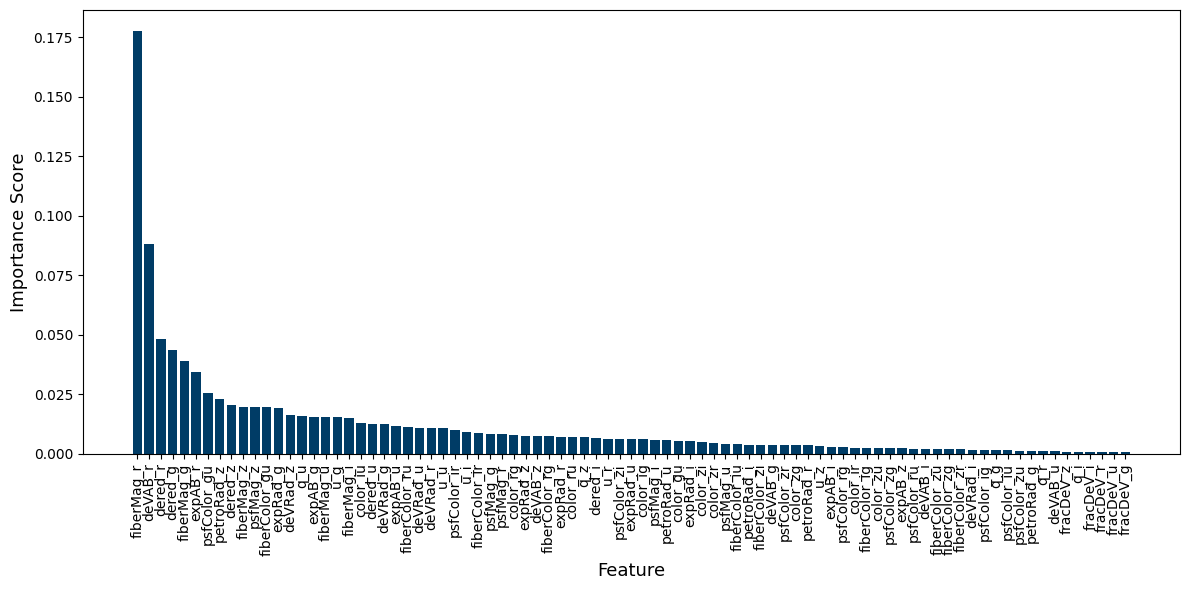

In [164]:
plt.figure(figsize=(12, 6))
plt.bar(total_occurrence_df['Feature'], total_occurrence_df['Feature_weights'], align='center', color='#003c66')
plt.xticks(range(X_train.shape[1]), total_occurrence_df['Feature'], rotation=90)
plt.xlabel('Feature', fontsize = 13)
plt.ylabel('Importance Score', fontsize = 13)
plt.tight_layout()
plt.show()

#### Rank vs Imporantance

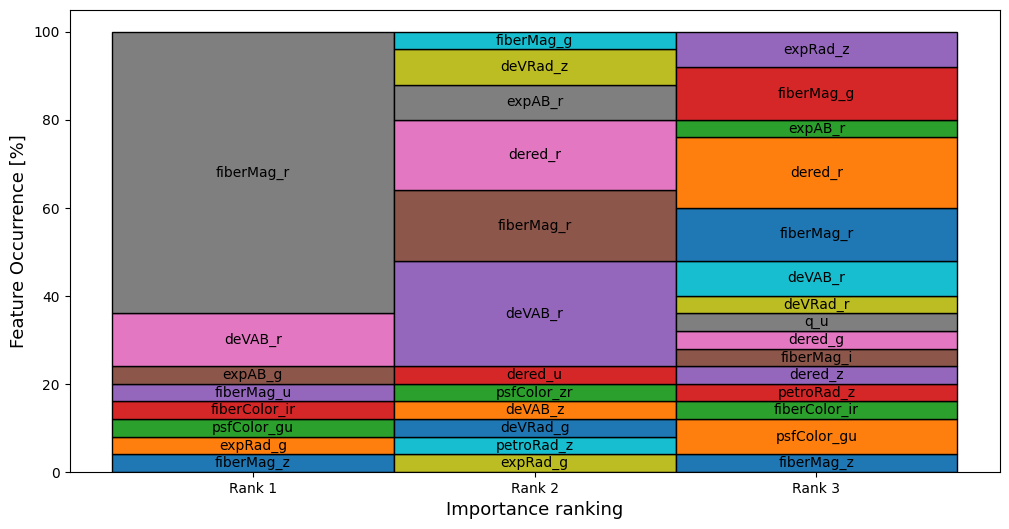

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

data = {
  "Rank": ["Rank 1", "Rank 2", "Rank 3"],
  "fiberMag_z": [4, 0, 4],
  "expRad_g": [4, 4, 0],
  "psfColor_gu": [4, 0, 8],
  "fiberColor_ir": [4, 0, 4], 
  "fiberMag_u":[4, 0, 0],
  "petroRad_z":[0, 4, 4],
  "deVRad_g":[0, 4, 0],
  "expAB_g":[4, 0, 0],
  "deVAB_z":[0, 4, 0],
  "psfColor_zr":[0, 4, 0],
  "dered_u":[0, 4, 0],
  "dered_z":[0, 0, 4],
  "fiberMag_i":[0, 0, 4],
  "dered_g":[0, 0, 4],
  "q_u":[0, 0, 4],
  "deVRad_r":[0, 0, 4],
  "deVAB_r": [12, 24, 8],
  "fiberMag_r": [64, 16, 12],
  "dered_r":[0, 16, 16],
  "expAB_r":[0, 8, 4],
  "deVRad_z":[0, 8, 0],
  "fiberMag_g":[0, 4, 12],
    "expRad_z":[0, 0, 8],
}

temp_df = pd.DataFrame(data)

fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 1

for i in range(len(temp_df)):
  bottom = 0
  for feature in temp_df.columns[1:]:
    if temp_df[feature][i] > 0:
      ax.bar(i, temp_df[feature][i], bar_width, bottom=bottom, label=feature, edgecolor='black')
      ax.text(i, bottom + temp_df[feature][i] / 2, feature, ha="center", va="center")
    bottom += temp_df[feature][i]

ax.set_xticks(range(len(temp_df)))
ax.set_xticklabels(temp_df["Rank"])

ax.set_ylabel("Feature Occurrence [%]", fontsize = 13)
ax.set_xlabel("Importance ranking", fontsize = 13)
plt.show()